In [1]:
pip install qiskit.ignis

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, assemble, transpile, Aer, IBMQ
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
# from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
from qiskit import execute

from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit.visualization import array_to_latex

# Loading your IBM Quantum account(s)

In [5]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
# provider = IBMQ.get_provider(hub='ibm')
real_backend = least_busy(provider.backends(filters=lambda x: not x.configuration().simulator))
# real_backend = provider.get_backend('ibm_lagos')
print("backend used: ", real_backend)

backend used:  ibmq_belem


In [6]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    oracle_qc.name = "oracle " + case
    return oracle_qc
    # oracle_gate = oracle_qc.to_gate()
    # oracle_gate.name = "Oracle" # To show when we display the circuit
    # return oracle_gate

In [7]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    # dj_circuit.barrier()
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    # dj_circuit.barrier()
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [8]:
aer_simulator = Aer.get_backend('aer_simulator')

In [9]:
n = 2

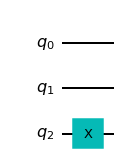

In [10]:
oracle_qc = dj_oracle('constant', n)
oracle_qc.draw()

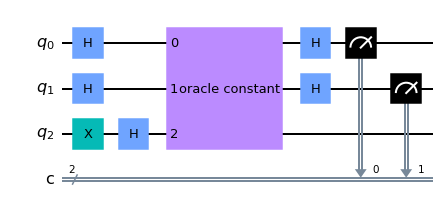

In [11]:
dj_circuit = dj_algorithm(oracle_qc, n)
dj_circuit.draw()

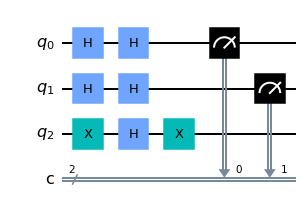

In [12]:
new_dj = dj_circuit.decompose('oracle constant')

new_dj.draw()

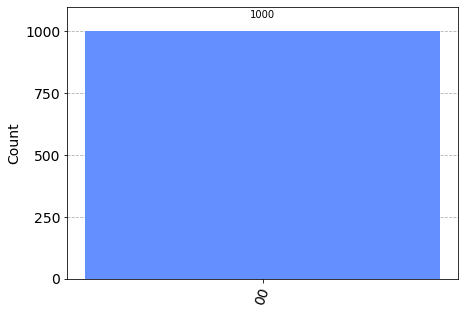

In [13]:
aer_backend = Aer.get_backend('aer_simulator')
aer_job = execute(dj_circuit, aer_backend, shots=1000)
aer_results = aer_job.result()
aer_counts = aer_results.get_counts()
plot_histogram(aer_counts)

In [14]:
job = execute(dj_circuit, real_backend, shots=1000)
realqc_results = job.result()

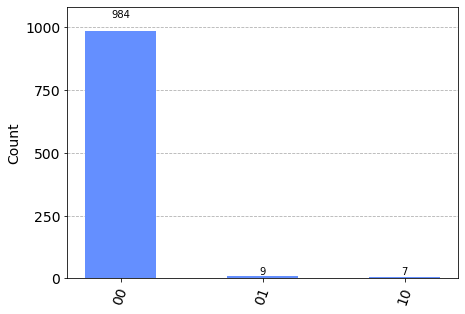

In [15]:
counts = realqc_results.get_counts()
plot_histogram(counts)

In [16]:
# QEM
qr = QuantumRegister(n)
qem_meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
qem_cal_results = real_backend.run(qem_meas_calibs, shots=10000).result()

In [17]:
meas_fitter = CompleteMeasFitter(qem_cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [ ]:
# cal_results = aer_simulator.run(qem_meas_calibs, shots=10000).result()
# meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
# array_to_latex(meas_fitter.cal_matrix)

In [18]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(realqc_results)
mitigated_counts = mitigated_results.get_counts()

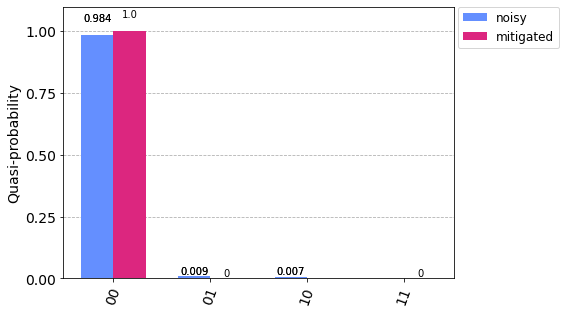

In [19]:
noisy_counts = realqc_results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [30]:
# GEM constant: left and write calib circuit sets are the same

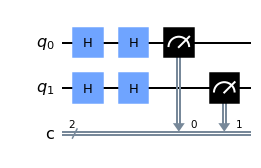

In [25]:
# not calibrating ancilla
dj_left0 = QuantumCircuit(n,n)
dj_left1 = QuantumCircuit(n) 
dj_left2 = QuantumCircuit(n)
dj_left3 = QuantumCircuit(n)

dj_left0.h(0)

dj_left0.h(0)

dj_left0.h(1)
dj_left0.h(1)
dj_left0.measure([0,1], [0,1])
dj_left0.draw()

/tmp/ipykernel_1305/923371719.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left1 += dj_left0


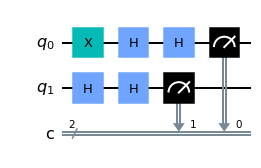

In [26]:
dj_left1.x(0)
dj_left1 += dj_left0

dj_left1.draw()

/tmp/ipykernel_1305/2252380090.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left2 += dj_left0


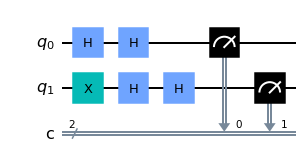

In [27]:
dj_left2.x(1)
dj_left2 += dj_left0
dj_left2.draw()

/tmp/ipykernel_1305/810308772.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left3 += dj_left0


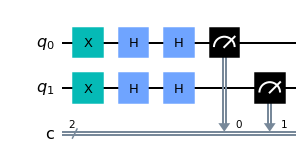

In [28]:
dj_left3.x(0)
dj_left3.x(1)
dj_left3 += dj_left0
dj_left3.draw()

In [31]:
meas_calibs = [dj_left0, dj_left1, dj_left2, dj_left3]

In [ ]:
# for circuit in meas_calibs:
#     print('Circuit',circuit.name)
#     print(circuit)

In [ ]:
# aer_sim = Aer.get_backend("aer_simulator")
# results = aer_sim.run(meas_calibs, shots=10000).result()
# result_counts = results.get_counts()
# print(result_counts)

In [ ]:
# aer_sim = Aer.get_backend("aer_simulator")
# t_qc = transpile(meas_calibs, aer_sim)
# qobj = assemble(t_qc, shots=10000)
# results = aer_sim.run(qobj, shots=10000).result()
# result_counts = results.get_counts()
# print(result_counts)

In [32]:
t_qc = transpile(meas_calibs, real_backend)
qobj = assemble(t_qc, shots=10000)
real_results = real_backend.run(qobj, shots=10000).result()

/tmp/ipykernel_1305/1499486007.py:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  real_results = real_backend.run(qobj, shots=10000).result()


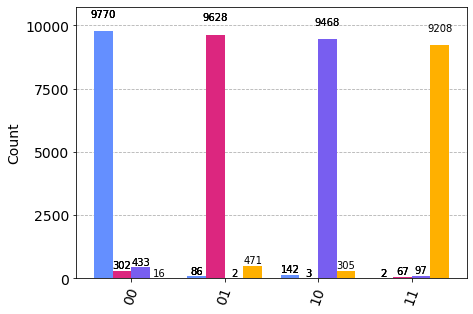

In [33]:
real_counts = real_results.get_counts()
plot_histogram(real_counts)

In [34]:
ls = []
for qc in meas_calibs:
     counts = real_results.get_counts(qc)
     this_array = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
     this_array = this_array/10000
     ls.append(this_array)
     print(this_array)
     # np.append(array, this_array, axis=1)
array = np.array(ls)
# print(array)
array_t = np.transpose(array)
print(array_t)

[9.77e-01 8.60e-03 1.42e-02 2.00e-04]
[3.020e-02 9.628e-01 3.000e-04 6.700e-03]
[4.330e-02 2.000e-04 9.468e-01 9.700e-03]
[0.0016 0.0471 0.0305 0.9208]
[[9.770e-01 3.020e-02 4.330e-02 1.600e-03]
 [8.600e-03 9.628e-01 2.000e-04 4.710e-02]
 [1.420e-02 3.000e-04 9.468e-01 3.050e-02]
 [2.000e-04 6.700e-03 9.700e-03 9.208e-01]]


In [35]:
array_to_latex(array)

<IPython.core.display.Latex object>

In [36]:
import scipy.linalg as la
array_inv = la.inv(array_t)
array_to_latex(array_inv)

<IPython.core.display.Latex object>

In [37]:
counts = realqc_results.get_counts()

In [38]:
result_array = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
result_array = result_array/1000

In [39]:
result_array

array([0.984, 0.009, 0.007, 0.   ])

In [40]:
mitigated = np.dot(array_inv, result_array)

In [43]:
array_to_latex(mitigated)

<IPython.core.display.Latex object>

In [41]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
normal = NormalizeData(mitigated)

In [48]:
array_to_latex(normal)

<IPython.core.display.Latex object>

In [44]:
def Normalize(arr):
    return arr/sum(arr)

In [45]:
new_normal = Normalize(mitigated)

In [47]:
array_to_latex(new_normal)

<IPython.core.display.Latex object>

In [ ]:
#Code below is obsolete

In [ ]:
# qr = QuantumRegister(n)
# meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
# cal_results = real_backend.run(meas_calibs, shots=10000).result()
# meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
# array_to_latex(meas_fitter.cal_matrix)

In [ ]:
# # Get the filter object
# meas_filter = meas_fitter.filter

# # Results with mitigation
# mitigated_results = meas_filter.apply(realqc_results)
# mitigated_counts = mitigated_results.get_counts()

In [ ]:
# mitigated_counts

In [ ]:
# def NormalizeData(data):
#     return (data - np.min(data)) / (np.max(data) - np.min(data))
# NormalizeData(mitigated)
# # https://www.stackvidhya.com/how-to-normalize-data-between-0-and-1-range/

In [ ]:
# meas_fitter = CompleteMeasFitter(results, state_labels)
# # , circlabel='mcal'circlabel='circuit
# array_to_latex(meas_fitter.cal_matrix)

In [ ]:
# t_qc = transpile(meas_calibs, real_backend)
# qobj = assemble(t_qc, shots=10000)



In [ ]:
# results = real_backend.run(qobj, shots=10000).result()

In [ ]:
# result_counts = results.get_counts()
# print(result_counts)

In [ ]:
# cal_results = real_backend.run(meas_calibs, shots=10000).result()

In [ ]:
# cal_results.get_counts()

In [ ]:
# meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
# array_to_latex(meas_fitter.cal_matrix)

In [ ]:
# # # Get the filter object
# meas_filter = meas_fitter.filter

# # # Results with mitigation
# # mitigated_results = meas_filter.apply(results)
# # mitigated_counts = mitigated_results.get_counts()

In [ ]:
#fitter would mitigate all results to 0

In [ ]:
# approach 1: reuse qiskit EM 
# Refer to https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

In [ ]:
# abandoned approach: create all columns of the calibration matrix from scratch.
# Then abandoned and used approach 2 instead.

In [ ]:
# job = execute(dj_left0, real_backend, shots=1000)
# results = job.result()
# counts = results.get_counts()

In [ ]:
# array0 = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
# array0 = array0/1000
# array0

In [ ]:
# job = execute(dj_left1, real_backend, shots=1000)
# results = job.result()
# counts = results.get_counts()

In [ ]:
# array1 = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
# array1 = array1/1000
# array1

In [ ]:
# job = execute(dj_left2, real_backend, shots=1000)
# results = job.result()
# counts = results.get_counts()

In [ ]:
# array2 = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
# array2 = array2/1000
# array2

In [ ]:
# job = execute(dj_left3, real_backend, shots=1000)
# results = job.result()
# counts = results.get_counts()

In [ ]:
# array3 = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
# array3 = array3/1000
# array3

In [ ]:
# array_left = np.array([array0, array1, array2, array3])

In [ ]:
# array_right = array_left

In [ ]:
# calib_mat = (array_left + array_right) / 2

In [ ]:
# array_to_latex(calib_mat)